In [4]:
import geemap as gee
import ee

# This is a workflow of accessing Landsat 8,9 collection 2 satellite data for the purpose of getting land surface temperature LST

More information about the dataset collection here :
https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/media/files/LSDS-1619_Landsat8-9-Collection2-Level2-Science-Product-Guide-v5.pdf

The important bands for accessing LST data are 'ST_B10'(estimated Surface Temperature) and 'QA_PIXEL'(quality assessment)

# Accesing datasets

In [5]:
#a interactive basemap is created here, any other layer added to the other cells will be shown here.
m = gee.Map()
m

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [ ]:
#'ST_B10', 'ST_ATRAN', 'ST_CDIST', 'ST_DRAD', 'ST_EMIS', 'ST_EMSD', 'ST_QA', 'ST_TRAD', 'ST_URAD'

In [3]:
dataset = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
    .filterDate('2017-06-01', '2017-07-01')

# Applies scaling factors.
def applyScaleFactors(image):
  opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
  thermalBand = image.select('ST_B6').multiply(0.00341802).add(149.0)
  return image.addBands(opticalBands, None, True) \
              .addBands(thermalBand, None, True)

dataset = dataset.map(applyScaleFactors)

visualization = {
  'bands': ['SR_B3', 'SR_B2', 'SR_B1'],
  'min': 0.0,
  'max': 0.3,
}

m.setCenter(-114.2579, 38.9275, 8)

m.addLayer(dataset, visualization, 'True Color (321)')

In [6]:
def fmask(image):
        # see https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC09_C02_T1_L2
        # Bit 0 - Fill
        # Bit 1 - Dilated Cloud
        # Bit 2 - Cirrus
        # Bit 3 - Cloud
        # Bit 4 - Cloud Shadow
        qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)

        # Apply the scaling factors to the appropriate bands.
        thermalBand = image.select('ST_B.*').multiply(0.00341802).add(149.0)#.substract(273.15) for Celsius, gives error

        # Replace the original bands with the scaled ones and apply the masks.
        return image.addBands(thermalBand, None, True).updateMask(qaMask)


dataset = ee.ImageCollection('LANDSAT/LC09/C02/T1_L2') \
            .filterDate('2022-05-14', '2022-09-24') \
            .map(fmask)

filtered_dataset = dataset.filter(ee.Filter.lt('CLOUD_COVER', 20))

meanLST = filtered_dataset.mean()

#valuesST = meanLST.select('ST_B10') for later making a histogram


visualization = {
  'bands': [ 'ST_B10'],
  'min': 273.15 +25,
  'max': 273.15 +60,
  'palette':['blue', 'white', 'red']
}

m.setCenter(46.738586, 24.774265, 8)

LST = m.addLayer(meanLST, visualization, 'True Color (432)')

In [7]:
#create split map
m.split_map( right_layer ='ROADMAP')

In [15]:
import geemap.foliumap as gee
#create html, does not work for now, returns grey map
m.to_html(filename="htmlMap.html", title='test', width='100%', height='880px')

# Clip datasets to areas of interest

In [ ]:
#WHEN WORKING WITH SHAPEFILES
#calculate statistics for shapefile data data

#load shapefile data
shapefile = '../shapefile.shp'
shapefile = geemap.shp_to_ee(shapefile)
#Map.addLayer(shapefile, {}, 'Shpex')


#directory and file name
out_dir = os.path.join(os.path.expanduser('~'), 'Downloads')
out_dem_stats = os.path.join(out_dir, 'dem_stats.csv')

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# Allowed output formats: csv, shp, json, kml, kmz
# Allowed statistics type: MEAN, MAXIMUM, MINIMUM, MEDIAN, STD, MIN_MAX, VARIANCE, SUM
geemap.zonal_statistics(meanLST, shapefile, out_dem_stats, statistics_type='MEAN', scale=1000)

In [6]:
# WHEN DRAWING POLYGONS
1#Crop image to drawn polygons
import numpy
import matplotlib.pyplot as plt
#draw a polygon first
roi = ee.FeatureCollection(m.draw_features)
selected_LST = meanLST.clip(roi)
selected_LST = selected_LST.select('ST_B10')
#need to do this, otherwise we get arrays with weird shapes
selected_LST = selected_LST.reproject(crs=ee.Projection('EPSG:3395'), scale=90)

# Downloading images

Generating URL ...
Please wait ...
Data downloaded to C:\Users\ebendo.BUROHAPPOLD\OneDrive - Buro Happold\Projects\00_DEVELOPMENT\geemap\filename.tif
(143, 160, 1)
[[[320.46863546]
  [320.82435369]
  [321.18373408]
  ...
  [323.88128429]
  [324.27533317]
  [324.28607552]]

 [[320.64588422]
  [320.78358159]
  [320.70179326]
  ...
  [324.05902133]
  [324.25726649]
  [324.26605568]]

 [[320.43884986]
  [320.46594988]
  [320.73817076]
  ...
  [324.2523836 ]
  [324.10589703]
  [324.01190148]]

 ...

 [[321.10927007]
  [321.13392864]
  [321.13563765]
  ...
  [320.11633526]
  [320.42053904]
  [320.87806543]]

 [[321.29066927]
  [321.26137196]
  [320.9842682 ]
  ...
  [320.76307347]
  [320.70765272]
  [320.66858963]]

 [[321.22426203]
  [321.16444668]
  [320.92079068]
  ...
  [321.18519894]
  [321.15834307]
  [321.33119723]]]


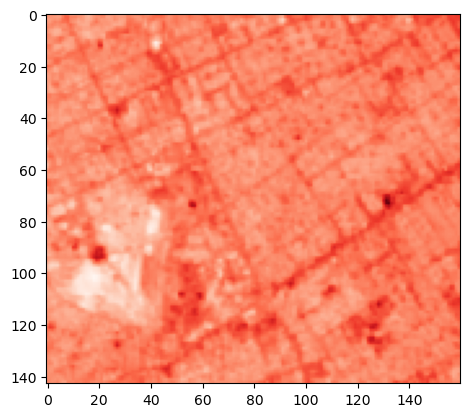

In [17]:
feature = m.draw_last_feature
aoi = feature.geometry()
#export image - gives a corrupt file
#gee.ee_export_image(
#    selected_LST, filename="filename.tif", scale=90,region=aoi, file_per_band=False
#)

rgb_img = gee.ee_to_numpy(selected_LST, region=aoi)
print(rgb_img.shape)
plt.imshow(rgb_img, cmap ="Reds")
plt.savefig(fname="file")
print(rgb_img)

In [ ]:
#when working with images
import ee
import geemap
import os


image = ee.Image('LANDSAT/LE7_TOA_5YEAR/1999_2003')

landsat_vis = {'bands': ['B4', 'B3', 'B2'], 'gamma': 1.4}
m.addLayer(image, landsat_vis, "LE7_TOA_5YEAR/1999_2003", True, 0.7)

(373, 531, 3)


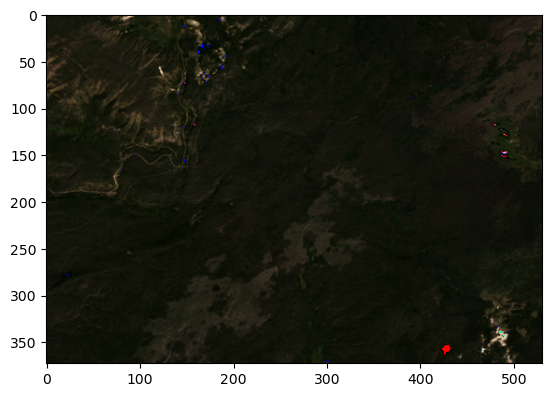

In [8]:
#get image for given polygon as numpy array and then plot

import ee
import geemap
import numpy as np
import matplotlib.pyplot as plt

ee.Initialize()

img = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_038029_20180810').select(['B4', 'B3', 'B2'])

aoi = ee.Geometry.Polygon(
    [[[-110.8, 44.7], [-110.8, 44.6], [-110.6, 44.6], [-110.6, 44.7]]], None, False
)

rgb_img = geemap.ee_to_numpy(img, region=aoi)
print(rgb_img.shape)

# Scale the data to [0, 255] to show as an RGB image.
# Adapted from https://bit.ly/2XlmQY8. Credits to Justin Braaten
rgb_img_test = (255 * ((rgb_img[:, :, 0:3] - 100) / 3500)).astype('uint8')
plt.imshow(rgb_img_test)
plt.show()

# Timelapse

In [1]:
import os
import ee
import geemap
from geemap import cartoee

%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
Map = geemap.Map()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [3]:
lon = 46.738586
lat = 24.774265
start_year = 2013
end_year = 2020

point = ee.Geometry.Point(lon, lat)
years = ee.List.sequence(start_year, end_year)


def get_best_image(year):
    start_date = ee.Date.fromYMD(year, 1, 1)
    end_date = ee.Date.fromYMD(year, 12, 31)
    image = (
        ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
        .filterBounds(point)
        .filterDate(start_date, end_date)
        .sort("CLOUD_COVER")
        .first()
    )
    
    thermalBand = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    image.addBands(thermalBand, None, True)
    return ee.Image(image)


collection = ee.ImageCollection(years.map(get_best_image))

In [4]:
vis_params = {"bands": ['ST_B10'], 'min': (48600),
  'max': (50000),
  'palette':['blue', 'white', 'red']}

image = ee.Image(collection.first())
Map.addLayer(image, vis_params, 'First image')
Map.setCenter(lon, lat, 8)
Map

Map(bottom=754.0, center=[24.774265, 46.738586], controls=(WidgetControl(options=['position', 'transparent_bg'…

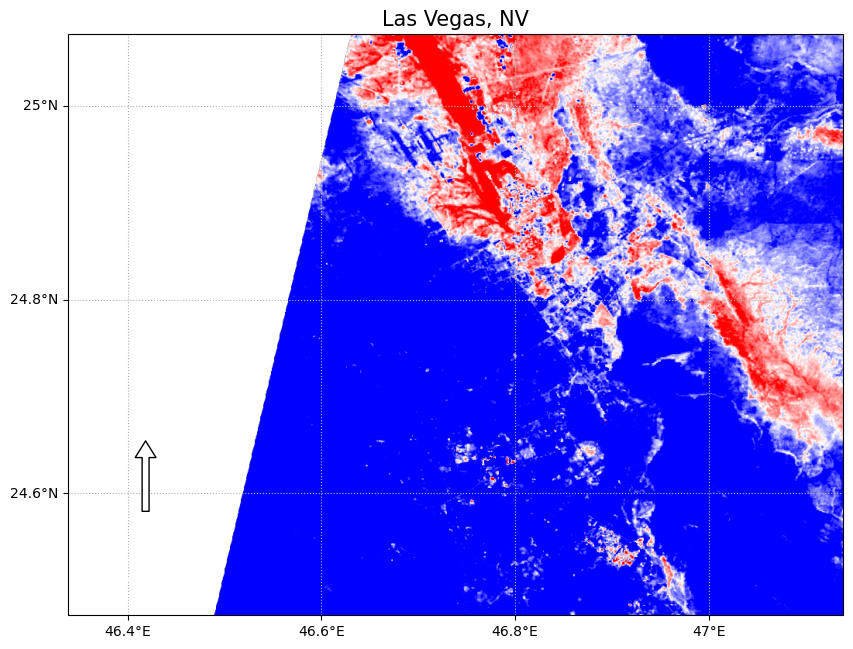

In [5]:
w = 0.4
h = 0.3

region = [lon + w, lat - h, lon - w, lat + h]

fig = plt.figure(figsize=(10, 8))

# use cartoee to get a map
ax = cartoee.get_map(image, region=region, vis_params=vis_params)

# add gridlines to the map at a specified interval
cartoee.add_gridlines(ax, interval=[0.2, 0.2], linestyle=":")

# add north arrow
north_arrow_dict = {
    "text": "N",
    "xy": (0.1, 0.3),
    "arrow_length": 0.15,
    "text_color": "white",
    "arrow_color": "white",
    "fontsize": 20,
    "width": 5,
    "headwidth": 15,
    "ha": "center",
    "va": "center",
}
cartoee.add_north_arrow(ax, **north_arrow_dict)

# add scale bar
scale_bar_dict = {
    "length": 10,
    "xy": (0.1, 0.05),
    "linewidth": 3,
    "fontsize": 20,
    "color": "white",
    "unit": "km",
    "ha": "center",
    "va": "bottom",
}
cartoee.add_scale_bar_lite(ax, **scale_bar_dict)

ax.set_title(label='LST', fontsize=15)

show()

In [6]:
cartoee.get_image_collection_gif(
    ee_ic=collection,
    out_dir=os.path.expanduser("~/Downloads/timelapse"),
    out_gif="animation.gif",
    vis_params=vis_params,
    region=region,
    fps=5,
    mp4=True,
    grid_interval=(0.2, 0.2),
    plot_title="Riyadh, LST",
    date_format='YYYY-MM-dd',
    fig_size=(10, 8),
    dpi_plot=100,
    file_format="png",
    north_arrow_dict=north_arrow_dict,
    scale_bar_dict=scale_bar_dict,
    verbose=True,
)

GIF saved to C:\Users\ebendo.BUROHAPPOLD\Downloads\timelapse\animation.gif
MP4 saved to C:\Users\ebendo.BUROHAPPOLD\Downloads\timelapse\animation.mp4
